## Importing libs

In [4]:
import torch 
from torch import nn
import torchvision 
import imutils
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import cv2
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"cv2 version: {cv2.__version__}")


%matplotlib inline

torch version: 2.0.1
torchvision version: 0.15.2
cv2 version: 4.8.1


In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device chosen: {DEVICE}")

Device chosen: cuda


## Loading and processing pictures

#### Data source

https://www.kaggle.com/datasets/ashwingupta3012/male-and-female-faces-dataset/download?datasetVersionNumber=1

Unzip it into *project_dir*/data

data folder should include two folders: *Female Faces* and *Male Faces*

In [6]:
MALE_PICTURES_DIR = os.path.join("..", "data", "Male Faces")
male_picture_files = [f for f in os.listdir(MALE_PICTURES_DIR)]
FEMALE_PICTURES_DIR = os.path.join("..", "data", "Female Faces")
female_picture_files = [f for f in os.listdir(FEMALE_PICTURES_DIR)]
len(male_picture_files), len(female_picture_files)

(2720, 2698)

In [7]:
def read_and_process_pictures(
    picture_dir: str,
    picture_filenames: list[str],
    resize_resolution: tuple[int, int],
    category: int,
):
    processed_images = None
    none_images_count = 0
    for picture_filename in picture_filenames:
        image = cv2.imread(os.path.join(picture_dir, picture_filename))
        if image is None:
            none_images_count += 1
            continue
        processed_image = np.swapaxes(cv2.resize(image, resize_resolution), -1, 0) / 255
        if processed_images is None:
            processed_images = np.array([processed_image])
        else:
            processed_images = np.append(processed_images, [processed_image], 0)
    print(f"Failed to read {none_images_count} out of {len(picture_filenames)} images")
    category_array = [0, 0]
    category_array[category] = 1
    return (
        processed_images.astype(np.float32),
        np.array([category_array] * len(processed_images), dtype=np.float32),
    )

In [8]:
male_processed_pictures = read_and_process_pictures(MALE_PICTURES_DIR, male_picture_files, (64, 64), 0)
female_processed_pictures = read_and_process_pictures(FEMALE_PICTURES_DIR, female_picture_files, (64, 64), 1)

Failed to read 0 out of 2720 images
Failed to read 0 out of 2698 images


In [9]:
X, y = torch.from_numpy(
    np.append(male_processed_pictures[0], female_processed_pictures[0], 0)
), torch.from_numpy(
    np.append(male_processed_pictures[1], female_processed_pictures[1], 0)
)

In [10]:
X_train, X_test, y_train, y_test = [
    arr.to(DEVICE)
    for arr in train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
]

In [11]:
dataloader_train = DataLoader(
    [list([X_train[x], y_train[x]]) for x in range(len(X_train))],
    batch_size=32,
    shuffle=False,
)

dataloader_test = DataLoader(
    [list([X_test[x], y_test[x]]) for x in range(len(X_test))],
    batch_size=32,
    shuffle=False,
)


len(dataloader_train), len(dataloader_test)

(136, 34)

## Creating model

In [12]:
class MaleFemaleClassificationModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=5, stride=1),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=15, stride=1),
            nn.MaxPool2d(kernel_size=11, stride=1),
            nn.Flatten(),
            nn.Linear(in_features=(32**2 * 3), out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=2),
            nn.Softmax(1),
        )

    def forward(self, x: torch.tensor):
        return self.layer_stack(x)

In [13]:
model = MaleFemaleClassificationModel().to(DEVICE)
model

MaleFemaleClassificationModel(
  (layer_stack): Sequential(
    (0): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(3, 3, kernel_size=(15, 15), stride=(1, 1))
    (3): MaxPool2d(kernel_size=11, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3072, out_features=300, bias=True)
    (6): ReLU()
    (7): Linear(in_features=300, out_features=100, bias=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): ReLU()
    (11): Linear(in_features=100, out_features=2, bias=True)
    (12): Softmax(dim=1)
  )
)

## Creating train and test functions

In [14]:
def train(model: nn.Module, optimizer, loss_fn, device: torch.device, dataloader: DataLoader) -> tuple[nn.Module, float]:
    model = model.to(device)
    model.train()
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        
        loss = loss_fn(preds.cpu(), labels.cpu())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 50 == 0 or batch == len(dataloader) - 1:
            # clear_output(True)
            print(f"Batch {batch + 1} / {len(dataloader)}")
    return [model, loss.item()]

In [15]:
def test(model: nn.Module, loss_fn, device: torch.device, dataloader: DataLoader) -> tuple[nn.Module, float, float]:
    model = model.to(device)
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.inference_mode():
        for _, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)

            loss = loss_fn(preds.cuda(), labels.cuda())
            total_loss += loss
            accuracy = (preds.argmax(1) == labels.argmax(1)).sum().item() / len(labels)
            total_accuracy += accuracy
        total_loss /= len(dataloader)
        total_accuracy /= len(dataloader)
    return [model, total_loss, total_accuracy]

## Choosing loss function and optimizer

In [49]:
LR = 0.00001

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

## Training and evaluating the model

In [50]:
models = pd.DataFrame(
    {
        "eval_acc": [],
        "eval_loss": [],
        "train_loss": [],
        "model": [],
    }
)

In [51]:
NUM_EPOCHS = 5

In [52]:
for epoch in range(NUM_EPOCHS):
    train_res = train(model, optimizer, loss_fn, DEVICE, dataloader_train)
    clear_output()
    print(f"Test accuracy: {train_res[1]:.5f}")
    test_res = test(model, loss_fn, DEVICE, dataloader_test)
    print(
        f"Eval loss: {test_res[1]:.5f}\
          \nEval accuracy: {test_res[2]}"
    )
    models = pd.concat([models, pd.DataFrame(
        {
            "eval_acc": test_res[2],
            "eval_loss": test_res[1].item(),
            "train_loss": train_res[1],
            "model": [test_res[0]],
        }, index=[len(models)]
    )])

Test accuracy: 0.00191
Eval loss: 0.11307          
Eval accuracy: 0.9816176470588235


## Selecting best model

In [53]:
models.sort_values(by=['eval_loss', 'eval_acc', 'train_loss'], ascending=[True, False, True]).head()

,eval_acc,eval_loss,train_loss,model
2,0.981618,0.112816,0.002294,MaleFemaleClassificationModel(\n (layer_stack...
3,0.981618,0.112833,0.002082,MaleFemaleClassificationModel(\n (layer_stack...
4,0.981618,0.113068,0.001910,MaleFemaleClassificationModel(\n (layer_stack...
1,0.977941,0.113157,0.002502,MaleFemaleClassificationModel(\n (layer_stack...
0,0.977022,0.114293,0.002785,MaleFemaleClassificationModel(\n (layer_stack...


In [54]:
model_dict = models.sort_values(by=['eval_loss', 'eval_acc', 'train_loss'], ascending=[True, False, True]).iloc[0]
model_dict

eval_acc                                               0.981618
eval_loss                                              0.112816
train_loss                                             0.002294
model         MaleFemaleClassificationModel(\n  (layer_stack...
Name: 2, dtype: object

In [55]:
model = models.iloc[0]['model']

## Testing model on random pictures

In [56]:
index_to_label = {
    0: 'male',
    1: 'female'
}

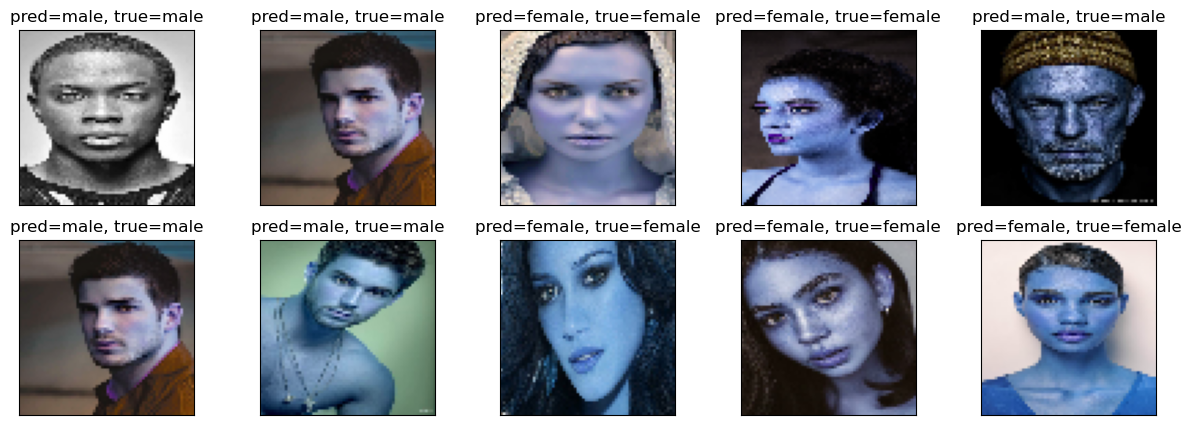

In [57]:
rand_images = []
for rand_index in torch.randint(0, len(X_test), size=[10]):
    label = y_test[rand_index]
    image = X_test[rand_index]
    
    image = image.to(DEVICE)
    pred = model(image.unsqueeze(0)).argmax()
    image = image.cpu()
    rand_images.append([image, pred, label])
fig, ax = plt.subplots(2, 5)
fig.set_figheight(5)
fig.set_figwidth(15)
c = 0
for i in range(2):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(
            f"pred={index_to_label[rand_images[c][1].item()]}, true={index_to_label[rand_images[c][2].argmax().item()]}"
        )
        ax[i, j].imshow(imutils.rotate(rand_images[c][0].permute(2, 1, 0).numpy().astype(np.float32), 0))
        c += 1

## Saving the model

In [58]:
SAVE_MODEL = True

In [59]:
if SAVE_MODEL:
    torch.save(model, '../models/male_female_cnn_model.pickle')